# Area Aggregation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
DIR = "/workspace/nflbigdatabowl2023"
sys.path.append(DIR)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt

from ast import literal_eval

from src.visualization.interactive_play_selector import create_interactive_play_selector

In [4]:
df_play_metrics_all = pd.read_csv(f"{DIR}/data/outputs/play_metrics.csv")
df_plays_all = pd.read_csv(f"{DIR}/data/raw/plays.csv")

In [5]:
cols = ["gameId", "playId", "method", "median_area", "time_start", "time_end", "area_start", "area_end"]
df_median_areas = df_play_metrics_all.query("window_type == 'before_end'")
df_median_areas[cols].query("method == 'passer_radius'").head()

,gameId,playId,method,median_area,time_start,time_end,area_start,area_end
4,2021090900,97,passer_radius,43.640806,1.8,3.8,74.509153,16.744689
16,2021090900,137,passer_radius,60.827831,1.2,3.2,81.211741,18.612366
28,2021090900,187,passer_radius,89.498320,0.6,2.6,111.311968,66.427406
40,2021090900,282,passer_radius,78.587883,1.8,3.8,66.182047,51.453319
52,2021090900,349,passer_radius,33.407696,1.2,3.2,87.590431,6.249256


In [6]:
def unsnake(raw: str) -> str:
    cleaned = raw.lower()
    words = []
    for word in cleaned.split("_"):
        letters = list(word)
        letters[0] = letters[0].upper()
        word = "".join(letters)
        words.append(word)
    return " ".join(words)

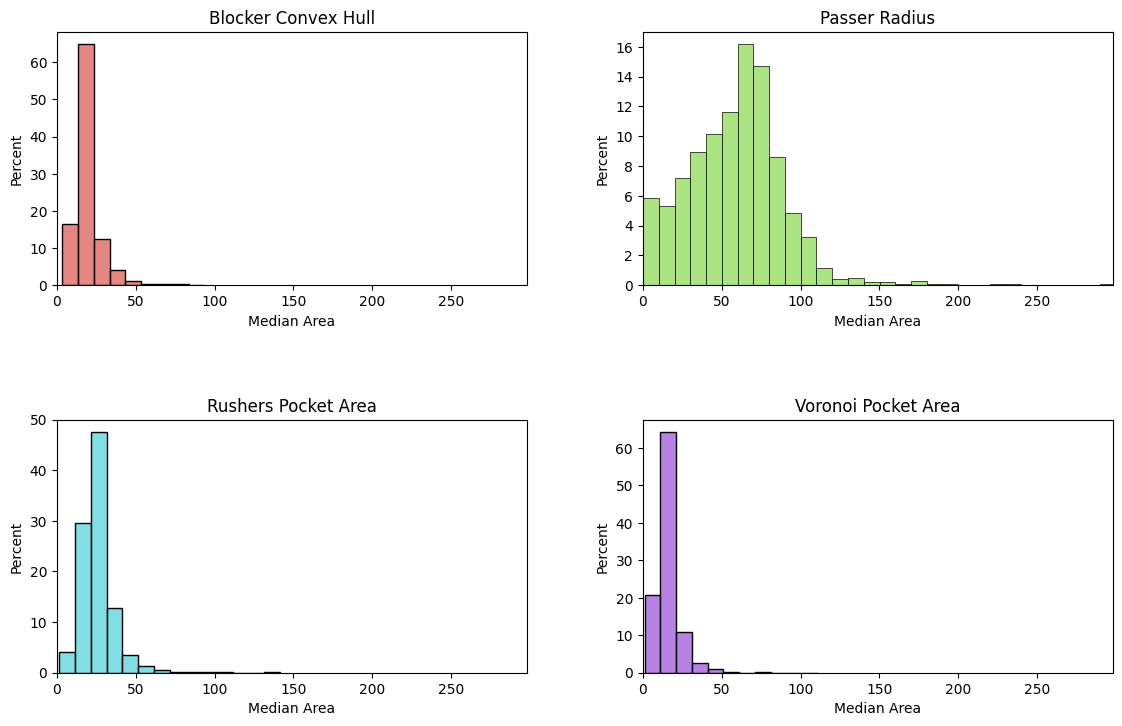

In [7]:
area_methods = list(df_median_areas["method"].unique())
fig, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(area_methods) / 2.0)))
axes = [ax for row in axes for ax in row]
pal = sns.hls_palette(len(area_methods))
x_max = df_median_areas["median_area"].max()
for i, method in enumerate(area_methods):
    ax = axes[i]
    color = pal[i]
    ser = df_median_areas["median_area"][df_median_areas.method == method]
    sns.histplot(ser, ax=ax, stat="percent", binwidth=10, color=color)
    ax.set_xlim(0, x_max)
    ax.set_title(unsnake(method))
    ax.set_xlabel("Median Area")
fig.tight_layout()
fig.set_size_inches(12, 8)
plt.show()

In [8]:
df_plays_all["offenseFormation"] = df_plays_all["offenseFormation"].fillna("MISSING")
formations = list(df_plays_all["offenseFormation"].unique())
df_play_info = df_median_areas.merge(df_plays_all, on=["gameId", "playId"], how="left")

In [9]:
def plot_formation_distribution(method: str, formation: str):
    fig, ax = plt.subplots(1, 1)
    color = sns.hls_palette(len(formations))[formations.index(formation)]
    df = df_play_info.query(f"method == '{method}'")
    ser = df["median_area"][df["offenseFormation"] == formation]
    ax.set_xlim(0, x_max)
    ax.set_title(unsnake(formation))
    ax.set_xlabel("Median Area")
    if len(ser) < 2:
        return
    sns.histplot(ser, ax=ax, stat="count", binwidth=10, color=color)
    plt.show()

In [10]:
def plot_all_formation_distributions(method: str):
    df = df_play_info.query(f"method == '{method}'")
    formations = df["offenseFormation"].unique()
    fig, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(formations) / 2.0)))
    axes = [ax for row in axes for ax in row]
    pal = sns.hls_palette(len(formations))
    x_max = df["median_area"].max()
    y_max = df.groupby(["offenseFormation"])["gameId"].count().max()
    for i, formation in enumerate(formations):
        ax = axes[i]
        color = pal[i]
        ax.set_xlim(0, x_max)
        ax.set_ylim(0, y_max)
        ax.set_title(unsnake(formation))
        ax.set_xlabel("Median Area")
        ser = df["median_area"][df["offenseFormation"] == formation]
        if len(ser) < 2:
            continue
        sns.histplot(ser, ax=ax, stat="count", binwidth=10, color=color)
    fig.tight_layout()
    fig.set_size_inches(12, 8)
    plt.show()

In [11]:
method_dropdown = widgets.Dropdown(
    options=area_methods,
    value=area_methods[0],
)
_ = widgets.interact(
    plot_all_formation_distributions,
    method=method_dropdown
)

interactive(children=(Dropdown(description='method', options=('blocker_convex_hull', 'passer_radius', 'rushers…

In [12]:
formation_dropdown = widgets.Dropdown(
    options=formations,
    value=formations[0],
)
_ = widgets.interact(
    plot_formation_distribution,
    method=method_dropdown,
    formation=formation_dropdown,
)

interactive(children=(Dropdown(description='method', options=('blocker_convex_hull', 'passer_radius', 'rushers…

In [13]:
def get_data_table(method: str, formation: str):
    query = f"method == '{method}' and offenseFormation == '{formation}'"
    df = pd.DataFrame(df_play_info.query(query))
    df["team"] = df["possessionTeam"]
    df["time_in_pocket"] = df["frame_end"] - df["frame_start"]
    df["is_sack"] = (df["passResult"] == "S").astype(int)
    aggregations = {
        "plays": ("playId", len),
        "median_area": ("median_area", np.median),
        "median_time_in_pocket": ("time_in_pocket", np.median),
        "sack_rate": ("is_sack", np.mean),
    }
    df_gp = df.groupby(["team"]).agg(**aggregations).reset_index()
    df_out = df_gp.sort_values(by=["median_area"], ascending=False).reset_index()
    return df_out

In [14]:
def plot_teams_scatter(ax, color, df, col_x, col_y):
    # Plot averages
    x_mean = df[col_x].mean()
    y_mean = df[col_y].mean()
    line_kwargs = dict(linestyle="--", color="lightgray", linewidth=1)
    ax.axvline(x_mean, **line_kwargs)
    ax.axhline(y_mean, **line_kwargs)
    # Plot data
    ax.scatter(df[col_x], df[col_y], color=color)
    for tup in df[["team", col_x, col_y]].itertuples(index=False):
        team, x, y = tup
        ax.text(x, y, team)
    # Configure plot
    ax.set_xlabel(unsnake(col_x))
    ax.set_ylabel(unsnake(col_y))

def plot_team_stats(method: str, formation: str):
    plt.close()
    fig, axes = plt.subplots(2, 1)
    df = get_data_table(method, formation)
    pal = sns.hls_palette(2)
    title = unsnake(f"Formation:_{formation},_Area:_{method}")
    [ax.set_title(title) for ax in axes]
    plot_teams_scatter(axes[0], pal[0], df, "median_area", "sack_rate")
    plot_teams_scatter(axes[1], pal[1], df, "median_area", "median_time_in_pocket")
    fig.set_size_inches(10, 12)
    plt.show()

In [15]:
_ = widgets.interact(
    get_data_table,
    method=method_dropdown,
    formation=formation_dropdown,
)

interactive(children=(Dropdown(description='method', options=('blocker_convex_hull', 'passer_radius', 'rushers…

In [16]:
_ = widgets.interact(
    plot_team_stats,
    method=method_dropdown,
    formation=formation_dropdown,
)

interactive(children=(Dropdown(description='method', options=('blocker_convex_hull', 'passer_radius', 'rushers…